# Movie Review Sentiment Analysis
## CS 595A Final Project

#### Team member: Ke Feng & Fengyu He



This file contains all source code for the Movie Review Sentiment Analysis Project. 

The purpose of this project is to use machine learning to classify the movie review to the proper sentiment label.

source code:https://github.com/FengyuHe-97/CS595A

In [2]:
import numpy as np 
import pandas as pd 
import nltk
import os
import gc
from keras.preprocessing import sequence,text
from keras.preprocessing.text import Tokenizer
from sklearn.feature_extraction.text import CountVectorizer
from keras.models import Sequential
from keras.layers import Dense,Dropout,Embedding,LSTM,Conv1D,GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.utils import to_categorical
from keras.losses import categorical_crossentropy
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,f1_score
import matplotlib.pyplot as plt
import warnings
from nltk.util import ngrams

warnings.filterwarnings("ignore")
#pd.set_option('display.max_colwidth',100)
pd.set_option('display.max_colwidth', -1)

In [5]:
gc.collect()

75

# Import the dataset

The dataset is comprised of tab-separated files with phrases from the Rotten Tomatoes dataset. Ther are two data sets provided, train.tsv and test.tsv.
* train.tsv contains the phrases and their associated sentiment labels.
* test.tsv contains just phrases. You must assign a sentiment label to each phrase.
* The sentiment labels are:
```
0 - negative
1 - somewhat negative
2 - neutral
3 - somewhat positive
4 - positive
```


In [6]:
train = pd.read_csv('data/train.tsv', sep='\t')
test = pd.read_csv('data/test.tsv', sep='\t')

In [7]:
print(train.shape)
train.head()

(156060, 4)


,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2


In [8]:
print(test.shape)
test.head()

(66292, 3)


,PhraseId,SentenceId,Phrase
0,156061,8545,An intermittently pleasing but mostly routine effort .
1,156062,8545,An intermittently pleasing but mostly routine effort
2,156063,8545,An
3,156064,8545,intermittently pleasing but mostly routine effort
4,156065,8545,intermittently pleasing but mostly routine


In [9]:
train.loc[train.SentenceId == 2]

,PhraseId,SentenceId,Phrase,Sentiment
63,64,2,"This quiet , introspective and entertaining independent is worth seeking .",4
64,65,2,"This quiet , introspective and entertaining independent",3
65,66,2,This,2
66,67,2,"quiet , introspective and entertaining independent",4
67,68,2,"quiet , introspective and entertaining",3
68,69,2,quiet,2
69,70,2,", introspective and entertaining",3
70,71,2,introspective and entertaining,3
71,72,2,introspective and,3
72,73,2,introspective,2


# Explore the Dataset

First of all, we need to explore the dataset to find the characteristics of it.

**Here are some notice of this dataset:** 
* Review sentences have been shuffled from their original order. 
* Each Sentence in the given train and test set has already been parsed into many phrases by the Stanford parser. 
* Each phrase has a PhraseId. 
* Each sentence has a SentenceId to track which phrases belong to a single sentence.
* Phrases that are repeated (such as short/common words) are only included once in the data.


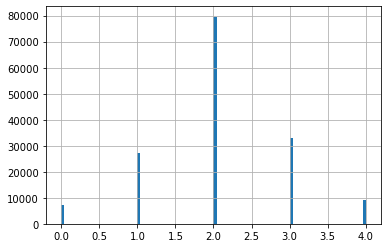

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

train["Sentiment"].hist(bins=100)


In [11]:
print('Average count of phrases per sentence in train is {0:.0f}.'.
      format(train.groupby('SentenceId')['Phrase'].count().mean()))
print('Average count of phrases per sentence in test is {0:.0f}.'.
      format(test.groupby('SentenceId')['Phrase'].count().mean()))

Average count of phrases per sentence in train is 18.
Average count of phrases per sentence in test is 20.


In [12]:
print('Number of phrases in train: {}. Number of sentences in train: {}.'.
      format(train.shape[0], len(train.SentenceId.unique())))
print('Number of phrases in test: {}. Number of sentences in test: {}.'.
      format(test.shape[0], len(test.SentenceId.unique())))

Number of phrases in train: 156060. Number of sentences in train: 8529.
Number of phrases in test: 66292. Number of sentences in test: 3310.


In [13]:
print('Average word length of phrases in train is {0:.0f}.'.
      format(np.mean(train['Phrase'].apply(lambda x: len(x.split())))))
print('Average word length of phrases in test is {0:.0f}.'.
      format(np.mean(test['Phrase'].apply(lambda x: len(x.split())))))

Average word length of phrases in train is 7.
Average word length of phrases in test is 7.


>By gathering the information above, we find that each sentence contains about 18-20 words average. And because the data has already been processed by the Stanford parser, phrases with the same Sentence Id contain each other. We can see that from the huge difference between the number of sentences and the number of phrases.  



Now let's find the feature for the reviews with positive sentiment. Because people would like to use multiple words to express their sentiment, so we counted the most frequent phrases with 3 words shown in the review.


In [14]:
text = ' '.join(train.loc[train.Sentiment == 4, 'Phrase'].values)
text_trigrams = [i for i in ngrams(text.split(), 3)]

In [15]:
from collections import Counter
Counter(text_trigrams).most_common(30)

[(('one', 'of', 'the'), 199),
 (('of', 'the', 'year'), 103),
 (('.', 'is', 'a'), 87),
 (('of', 'the', 'best'), 80),
 (('of', 'the', 'most'), 70),
 (('is', 'one', 'of'), 50),
 (('One', 'of', 'the'), 43),
 ((',', 'and', 'the'), 40),
 (('the', 'year', "'s"), 38),
 (('It', "'s", 'a'), 38),
 (('it', "'s", 'a'), 37),
 (('.', "'s", 'a'), 37),
 (('a', 'movie', 'that'), 35),
 (('the', 'edge', 'of'), 34),
 (('the', 'kind', 'of'), 33),
 (('of', 'your', 'seat'), 33),
 (('the', 'film', 'is'), 31),
 ((',', 'this', 'is'), 31),
 (('the', 'film', "'s"), 31),
 ((',', 'the', 'film'), 30),
 (('film', 'that', 'is'), 30),
 (('as', 'one', 'of'), 30),
 (('edge', 'of', 'your'), 29),
 ((',', 'it', "'s"), 27),
 (('a', 'film', 'that'), 27),
 (('as', 'well', 'as'), 27),
 ((',', 'funny', ','), 25),
 ((',', 'but', 'it'), 23),
 (('films', 'of', 'the'), 23),
 (('some', 'of', 'the'), 23)]

Now let's remove the stopwords. They are commonly used word (such as “the”, “a”, “an”, “in”) because they do not provide any practical meaning， they are usually programmed to ignore in a search engine.

In [16]:
from nltk.corpus import stopwords
nltk.download("stopwords")
text = ' '.join(train.loc[train.Sentiment == 4, 'Phrase'].values)
text = [i for i in text.split() if i not in stopwords.words('english')]
text_trigrams = [i for i in ngrams(text, 3)]
Counter(text_trigrams).most_common(30)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\59699\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[((',', 'funny', ','), 33),
 (('one', 'year', "'s"), 28),
 (('year', "'s", 'best'), 26),
 (('movies', 'ever', 'made'), 19),
 ((',', 'solid', 'cast'), 19),
 (('solid', 'cast', ','), 18),
 (("'ve", 'ever', 'seen'), 16),
 (('.', 'It', "'s"), 16),
 ((',', 'making', 'one'), 15),
 (('best', 'films', 'year'), 15),
 ((',', 'touching', ','), 15),
 (('exquisite', 'acting', ','), 15),
 (('acting', ',', 'inventive'), 14),
 ((',', 'inventive', 'screenplay'), 14),
 (('jaw-dropping', 'action', 'sequences'), 14),
 (('good', 'acting', ','), 14),
 (("'s", 'best', 'films'), 14),
 (('I', "'ve", 'seen'), 14),
 (('funny', ',', 'even'), 14),
 (('best', 'war', 'movies'), 13),
 (('purely', 'enjoyable', 'satisfying'), 13),
 (('funny', ',', 'touching'), 13),
 ((',', 'smart', ','), 13),
 (('inventive', 'screenplay', ','), 13),
 (('funniest', 'jokes', 'movie'), 13),
 (('action', 'sequences', ','), 13),
 (('sequences', ',', 'striking'), 13),
 ((',', 'striking', 'villains'), 13),
 (('exquisite', 'motion', 'picture')

By exploring the dataset we have some discovries:
* Punctuation mark should not be filtered because it can make a sentence have diffrent sentiment.
* We should consider the context of the words, so that ngrams need to be used.
* The number of instances of each sentiment is not balanced, we need to separate the validation set proportionally.

# Word counts feature with Simple model

First, try to preprocess the data set in a very simple way.
We build a dictionary that counts all the words that have appeared in the dataset, then take each word as a feature. After the process, the data set will be a matrix that has the columns equal to the number of words, and the rows equal to the number of instances. Elements inside the matrix are the number of how many times this feature shows in that instance.

Here is the offical site of the ContVectorizer:\
https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

### Data preprocess using CountVectorizer




In [17]:
# extract the phrases in the training and testing set and 
# combine them together for later cleaning the data.
train_sentences = train['Phrase']
test_sentences = test['Phrase']
sentences = pd.concat([train['Phrase'], test['Phrase']])
labels = train['Sentiment']

In [18]:
# import the stopword library
stop_words = open('./stopwords.txt', encoding='utf-8').read().splitlines()
print(sentences.shape, labels.shape, len(stop_words))

(222352,) (156060,) 435


In [19]:
# Because the testing set does not have the lable, 
# so seperata some data from the training set as the testing set. 

# x_train,x_test,y_train,y_test = train_test_split(
#     train_sentences,labels)
x_train,x_test,y_train,y_test=train_test_split(
    train_sentences,labels,test_size=0.2,stratify=labels)

In [20]:
#
cv = CountVectorizer(
    analyzer='word', # the features are made of word
    ngram_range=(1,4),# the range of words a feature can contain
    stop_words=stop_words, # filter out the stopwords in the library
    max_features=150000 # only consider the top max_features ordered 
                        # by the frequency
)
# cv.fit(sentences)
x_train = cv.fit_transform(x_train)
x_test = cv.transform(x_test)

In [21]:
# Here are the features collected
# print(cv.get_feature_names())

In [22]:
# the dataset after the process
# print(x_train.toarray())

In [23]:
x_train_CountVectorizer=x_train
x_test_CountVectorizer=x_test
y_train_CountVectorizer=y_train
y_test_CountVectorizer=y_test

### LogisticRegression with CountVectorizer data

In [24]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(x_train, y_train)
print(lg.score(x_test, y_test))

0.6479559143919006


### Naive_bayes with CountVectorizer data

In [25]:
from sklearn.naive_bayes import MultinomialNB
mu = MultinomialNB()
mu.fit(x_train,y_train)
print(mu.score(x_test,y_test))

0.609605280020505


We can see that, using some simple model such as LogisticRegression and Naive_bayes with the features like word count is not good enough.

# Try a new feature extraction method with complex model

In [26]:
# Adding Sentiment column to test datset for later to seperate them from the taining set 
test['Sentiment']=-999
test.head()

,PhraseId,SentenceId,Phrase,Sentiment
0,156061,8545,An intermittently pleasing but mostly routine effort .,-999
1,156062,8545,An intermittently pleasing but mostly routine effort,-999
2,156063,8545,An,-999
3,156064,8545,intermittently pleasing but mostly routine effort,-999
4,156065,8545,intermittently pleasing but mostly routine,-999


In [27]:
# joing train and test together for preprocessing for convenience
df=pd.concat([train,test],ignore_index=True)
print(df.shape)
df.tail()

(222352, 4)


,PhraseId,SentenceId,Phrase,Sentiment
222347,222348,11855,"A long-winded , predictable scenario .",-999
222348,222349,11855,"A long-winded , predictable scenario",-999
222349,222350,11855,"A long-winded ,",-999
222350,222351,11855,A long-winded,-999
222351,222352,11855,predictable scenario,-999


In [28]:
del train,test
gc.collect()

104

### Data preprocessing

In [29]:
from nltk.tokenize import word_tokenize
from nltk import FreqDist
from nltk.stem import SnowballStemmer,WordNetLemmatizer
stemmer=SnowballStemmer('english')
lemma=WordNetLemmatizer()
from string import punctuation
import re

The clean_review method is used to do the following process for the dataset:
* Replace non-letter characters in the text with spaces
* change to lowercase
* devide each sentence to words

In [30]:
def clean_review(review_col):
    review_corpus=[]
    for i in range(0,len(review_col)):
        review=str(review_col[i])
        #Replace non-letter characters in the text with spaces
        review=re.sub('[^a-zA-Z]',' ',review)
        #change to lowercase and devide each sentence to words
        #review=[stemmer.stem(w) for w in word_tokenize(str(review).lower())]
        review=[lemma.lemmatize(w) for w in word_tokenize(str(review).lower())]
        # conect the words with ' '
        review=' '.join(review)
        review_corpus.append(review)
    return review_corpus


The filter_stop_words method is to filter out all the stopwords in the text.

In [31]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
def filter_stop_words(train_sentences, stop_words):
    for i, sentence in enumerate(train_sentences):
        new_sent = [word for word in sentence.split() if word not in stop_words]
        train_sentences[i] = ' '.join(new_sent)
    return train_sentences

stop_words = set(stopwords.words("english"))

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\59699\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# Here are the typical stopwords
stopwords.words("english")

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Now use the above two methods to process the dataset.

In [33]:
import nltk
nltk.download('wordnet')
after_clean_review=clean_review(df.Phrase.values)
after_stop=filter_stop_words(after_clean_review,stop_words)
#df['clean_review']=clean_review(df.Phrase.values)
df['clean_review']=clean_review(after_stop)
df.head()

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\59699\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,PhraseId,SentenceId,Phrase,Sentiment,clean_review
0,1,1,"A series of escapades demonstrating the adage that what is good for the goose is also good for the gander , some of which occasionally amuses but none of which amounts to much of a story .",1,series escapade demonstrating adage good goose also good gander occasionally amuses none amount much story
1,2,1,A series of escapades demonstrating the adage that what is good for the goose,2,series escapade demonstrating adage good goose
2,3,1,A series,2,series
3,4,1,A,2,
4,5,1,series,2,series


### seperating train and test dataset

In [34]:
df_train=df[df.Sentiment!=-999]
df_train.shape

(156060, 5)

In [35]:
df_test=df[df.Sentiment==-999]
df_test.drop('Sentiment',axis=1,inplace=True)
print(df_test.shape)
df_test.head()

(66292, 4)


,PhraseId,SentenceId,Phrase,clean_review
156060,156061,8545,An intermittently pleasing but mostly routine effort .,intermittently pleasing mostly routine effort
156061,156062,8545,An intermittently pleasing but mostly routine effort,intermittently pleasing mostly routine effort
156062,156063,8545,An,
156063,156064,8545,intermittently pleasing but mostly routine effort,intermittently pleasing mostly routine effort
156064,156065,8545,intermittently pleasing but mostly routine,intermittently pleasing mostly routine


In [36]:
del df
gc.collect()

60

### Splitting 20% validation set

In [37]:
train_text=df_train.clean_review.values
test_text=df_test.clean_review.values
target=df_train.Sentiment.values
y=to_categorical(target)# like one hot encoder
print(train_text.shape,target.shape,y.shape)

(156060,) (156060,) (156060, 5)


In [38]:
# use stratify to make each class in the set are Proportional
X_train_text,X_val_text,target_train,target_val=train_test_split(
    train_text,target,test_size=0.2,stratify=y,random_state=123)
print(X_train_text.shape,target_train.shape)
print(X_val_text.shape,target_val.shape)

(124848,) (124848,)
(31212,) (31212,)


In [39]:
# change to the format like onehot encoder
y_train=to_categorical(target_train)
y_val=to_categorical(target_val)

In [40]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [41]:
print(X_train_text.shape,y_train.shape)
print(X_val_text.shape,y_val.shape)

(124848,) (124848, 5)
(31212,) (31212, 5)


In [42]:
X_train_text

array(['would force give millisecond thought', 'joyful', 'might enjoy',
       ..., 'c walsh', 'meander', 'think figured late marriage'],
      dtype=object)

# Building Keras LSTM model

### Finding number of unique words in training set

In [43]:
all_words=' '.join(X_train_text)
all_words=word_tokenize(all_words) # seperate the words
dist=FreqDist(all_words)
num_unique_word=len(dist)

In [44]:
print('number of unique words in training set {0:.0f}.'.
      format(num_unique_word))

number of unique words in training set 13601.


### Finding max length of a review in training set

In [45]:
r_len=[]
for text in X_train_text:
    word=word_tokenize(text)
    l=len(word)
    r_len.append(l)
    
MAX_REVIEW_LEN=np.max(r_len)
print('Max length of a review in training set {0:.0f}.'.
      format(MAX_REVIEW_LEN))

Max length of a review in training set 29.


In [46]:
max_features = num_unique_word
max_words = MAX_REVIEW_LEN
batch_size = 128
epochs = 10
num_classes=y.shape[1]

### Tokenize Text
This step will use the Tokenize class to transform the text of the dataset into a sequence of integers, the integers are the index of that word in the dictionary.

In [47]:
# Tokenizer allows to vectorize a text corpus,
# by turning each text into a sequence of integers
tokenizer = Tokenizer(num_words=max_features)# the maximum number of words to keep, based on word frequency
tokenizer.fit_on_texts(list(X_train_text))
X_train = tokenizer.texts_to_sequences(X_train_text)# Transforms each text in texts to a sequence of integers.
X_val = tokenizer.texts_to_sequences(X_val_text)
X_test = tokenizer.texts_to_sequences(test_text)

### Sequence padding

In order to achieve correctness, keras can only accept sequence input of the same length. Therefore, because the length of the current sequence is uneven, we use pad_sequences () to make them have the same length

In [48]:
X_train = sequence.pad_sequences(X_train, maxlen=max_words)
X_val = sequence.pad_sequences(X_val, maxlen=max_words)
X_test = sequence.pad_sequences(X_test, maxlen=max_words)
print(X_train.shape,X_val.shape,X_test.shape)

(124848, 29) (31212, 29) (66292, 29)


### LSTM model

We choose Long Short-Term Memory to solve this natural language processing problem. This LSTM support long-term dependency, allows the model to infer the next words based on the previous words.

we use tensorflow to build our LSTM. It has 4 sequntial layers. First is embedding layer, it can "turns positive integers (indexes) into dense vectors of fixed size", basically this layer can reduce the demension of the input vector. Followed by 2 LSTM layers and the output layer is dense layer, adding this fully connected layer is an effective way to learn nonlinear combinations between features.

In [49]:
model=Sequential()
model.add(Embedding(max_features,250,mask_zero=True))
model.add(LSTM(128,dropout=0.4, recurrent_dropout=0.4,return_sequences=True))
model.add(LSTM(64,dropout=0.5, recurrent_dropout=0.5,return_sequences=False))
model.add(Dense(num_classes,activation='softmax'))
model.compile(loss='categorical_crossentropy',optimizer=Adam(lr=0.001),metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 250)         3400250   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         194048    
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 325       
Total params: 3,644,031
Trainable params: 3,644,031
Non-trainable params: 0
_________________________________________________________________


In [52]:
X_train.shape

(124848, 29)

In [53]:
y_train

array([[0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [54]:
%%time
history=model.fit(X_train, y_train, validation_data=(X_val, y_val),
                  epochs=10, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/10
124848/124848 [==============================] - 149s 1ms/step - loss: 1.0298 - accuracy: 0.5967 - val_loss: 0.8794 - val_accuracy: 0.6462
Epoch 2/10
124848/124848 [==============================] - 151s 1ms/step - loss: 0.8335 - accuracy: 0.6636 - val_loss: 0.8473 - val_accuracy: 0.6596
Epoch 3/10
124848/124848 [==============================] - 151s 1ms/step - loss: 0.7731 - accuracy: 0.6857 - val_loss: 0.8407 - val_accuracy: 0.6647
Epoch 4/10
124848/124848 [==============================] - 155s 1ms/step - loss: 0.7328 - accuracy: 0.6999 - val_loss: 0.8501 - val_accuracy: 0.6615
Epoch 5/10
124848/124848 [==============================] - 160s 1ms/step - loss: 0.7000 - accuracy: 0.7122 - val_loss: 0.8503 - val_accuracy: 0.6659
Epoch 6/10
124848/124848 [==============================] - 135s 1ms/step - loss: 0.6725 - accuracy: 0.7204 - val_loss: 0.8631 - val_accuracy: 0.6602
Epoch 7/10
124848/124848 [=======================

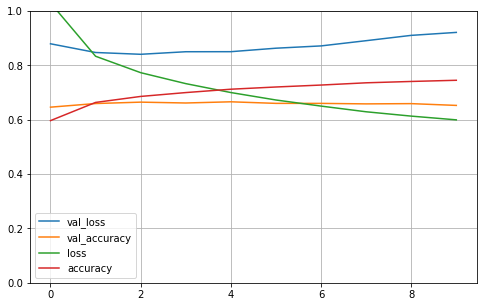

In [55]:
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd


pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)    
plt.gca().set_ylim(0, 1)
plt.show()

We can see that the average accuracy for the training set increases gradually with each epoch and ends up at 0.7455. The accuracy on the validation set grows slowly at first but as the epoch reaches 7, the accuracy starts decrease. We only need to train the model about 9 epochs. The performance still needs improvement.

In [56]:
y_pred=model.predict_classes(X_test)
y_pred

array([3, 3, 2, ..., 1, 1, 1], dtype=int64)

# Building CNN Model

 here we will use a simple Convolutional Neural Network.CNNs are fast and produce adequate enough results, so this will serve as a pretty good baseline for more sophisticated architectures revolving around CNNs.
 
 we use keras to build a CNN . Since data is one-dimensional, we only need one-dimensional convolutions. Since this problem is multi-class classification, we will optimize the categorical crossentropy loss function. The optimizer we will use is ADAM.

In [57]:
from keras.layers import Input, Dense, Embedding, Flatten
from keras.layers import SpatialDropout1D
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

In [58]:
model = Sequential()
max_features = 20000
maxlen = 29
# Input / Embdedding
model.add(Embedding(max_features, 150, input_length=maxlen))

# CNN
model.add(SpatialDropout1D(0.2))

model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

# Output layer
model.add(Dense(5, activation='sigmoid'))

In [59]:
epochs = 5
batch_size = 32

In [60]:

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
124848/124848 [==============================] - 190s 2ms/step - loss: 0.9814 - accuracy: 0.6006 - val_loss: 0.8541 - val_accuracy: 0.6449
Epoch 2/5
124848/124848 [==============================] - 160s 1ms/step - loss: 0.7828 - accuracy: 0.6727 - val_loss: 0.8251 - val_accuracy: 0.6576
Epoch 3/5
124848/124848 [==============================] - 170s 1ms/step - loss: 0.7060 - accuracy: 0.7018 - val_loss: 0.8403 - val_accuracy: 0.6612
Epoch 4/5
124848/124848 [==============================] - 163s 1ms/step - loss: 0.6543 - accuracy: 0.7219 - val_loss: 0.8603 - val_accuracy: 0.6608
Epoch 5/5
124848/124848 [==============================] - 160s 1ms/step - loss: 0.6149 - accuracy: 0.7355 - val_loss: 0.8828 - val_accuracy: 0.6598


For the CNN model, we can see that even though the training set accuracy keeps increasing, the performance on the validation set is not increasing as well, it actually drops a little at the 5th epoch, so we stop training the model because it is going to overtraining. So that the overall accuracy is about 0.66, a little bit better than the LSTM model but still needs improvement.

# Try this new feature extraction method on the simple model

### LogisticRegression

In [61]:
from sklearn.linear_model import LogisticRegression

lg = LogisticRegression()
lg.fit(X_train, target_train)
print(lg.score(X_val, target_val))

0.51079712930924


### naive_bayes

In [62]:
mu = MultinomialNB()
mu.fit(X_train, target_train)
print(mu.score(X_val, target_val))

0.4624503396129694


We can see that vectorize the words in the text is not a good feature for Logistic Regression and Naive Bayes model, the accuracy for those 2 models are 0.51 and 0.46 respectively. 

# Try to use the word frequency feature extraction on the complex model

### CNN model for CountVectorizer data

In [63]:
model = Sequential()
max_features = 20000
maxlen = 150000
# Input / Embdedding
model.add(Embedding(max_features, 150, input_length=maxlen))

# CNN
model.add(SpatialDropout1D(0.2))

model.add(Conv1D(32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Conv1D(64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))

model.add(Flatten())

# Output layer
model.add(Dense(5, activation='sigmoid'))

In [64]:
epochs = 5
batch_size = 32

We can see that the estimated time of 1 epoch needs about 10 hours. But only one epoch is not enough to train the model, so even though this maybe a good solution for this problem, we have to give up.

In [65]:
y_train_CountVectorizer=to_categorical(y_train_CountVectorizer)
y_test_CountVectorizer=to_categorical(y_test_CountVectorizer)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(x_train_CountVectorizer, y_train_CountVectorizer, validation_data=(x_test_CountVectorizer, y_test_CountVectorizer), epochs=epochs, batch_size=batch_size, verbose=1)

Train on 124848 samples, validate on 31212 samples
Epoch 1/5
    64/124848 [..............................] - ETA: 10:06:08 - loss: 1.9370 - accuracy: 0.3906

KeyboardInterrupt: 